In [59]:
import torch 
import torchvision
from torchvision import transforms
import torchvision.datasets as datasets
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os
from glob import glob
from PIL import Image

### Data Loading

Our dataset is the HAM1000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin legions. We accessed our data at [the Harvard Dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T).

In [60]:
df_data = pd.read_csv("HAM10000_metadata")
df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


First, perform data preparation.

In [61]:
img_path = {os.path.splitext(os.path.basename(x))[0]: x for x in glob((os.path.join('*', '*.jpg')))}

df_data['img_path'] = df_data['image_id'].map(img_path.get)

#drop rows with no image path
df_data.dropna(inplace=True)
df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,img_path
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,HAM10000_images_part_1/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,HAM10000_images_part_1/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,HAM10000_images_part_1/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,HAM10000_images_part_2/ISIC_0031633.jpg
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,vidir_modern,HAM10000_images_part_1/ISIC_0025837.jpg


In [62]:
def load_image(image_path):
    try:
        image = Image.open(image_path)
        return np.asarray(image.resize((32, 32)))
    except Exception as e:
        print(f"Error loading image '{image_path}': {e}")
        return None

In [63]:
def transpose(img):
    '''
    Apply transpose to an image such that the color channels are first
    '''
    return np.transpose(img, (2, 0 ,1))

In [64]:
# change image shape in entire dataset
df_data['img'] = df_data['img_path'].map(load_image)
df_data['img'] = df_data['img'].apply(transpose)

# drop na values 
df_data.dropna()

# take a look at dataset
df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,img_path,img
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,HAM10000_images_part_1/ISIC_0025030.jpg,"[[[24, 56, 106, 143, 167, 173, 177, 178, 185, ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,HAM10000_images_part_1/ISIC_0026769.jpg,"[[[190, 199, 200, 205, 207, 207, 209, 201, 199..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,HAM10000_images_part_1/ISIC_0025661.jpg,"[[[35, 83, 128, 161, 174, 180, 191, 192, 199, ..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,HAM10000_images_part_2/ISIC_0031633.jpg,"[[[155, 188, 210, 220, 228, 233, 235, 234, 238..."
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,vidir_modern,HAM10000_images_part_1/ISIC_0025837.jpg,"[[[122, 158, 179, 184, 191, 188, 194, 195, 199..."


In [65]:
print("df shape: ", df_data.shape)
print("shape of an image: ", df_data['img'].iloc[10].shape)

df shape:  (8039, 10)
shape of an image:  (3, 32, 32)


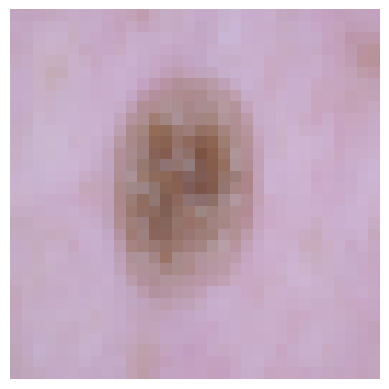

In [66]:
# example of plotting an image
img = df_data['img'].iloc[10]
img = np.transpose(img, (1, 2, 0))
plt.imshow(img, cmap = "Greys_r")
plt.gca().axis("off")
plt.show()

In [67]:
from sklearn.model_selection import train_test_split

# train test split
X_train, X_test, y_train, y_test = train_test_split(df_data[['lesion_id', 'img']], df_data['dx'], test_size=0.2, random_state=42)

# X_train has lesion_id and img
X_train.head()

,lesion_id,img
1156,HAM_0000827,"[[[168, 176, 178, 179, 178, 185, 184, 184, 191..."
373,HAM_0001389,"[[[140, 148, 154, 163, 165, 171, 172, 172, 173..."
5382,HAM_0002885,"[[[242, 234, 240, 244, 244, 245, 247, 246, 246..."
6162,HAM_0002309,"[[[232, 233, 236, 236, 237, 237, 239, 239, 240..."
7735,HAM_0006567,"[[[183, 182, 184, 185, 187, 190, 190, 191, 192..."


### First Logistic Regression Model

How does a simple logistic regression model perform on images flattened into a list of pixel color values?

In [68]:
n, p = X_train.shape[0], X_train.shape[1] - 1

img_tensors = [torch.Tensor(img) for img in X_train['img'].values]
X_train['img_tensor'] = img_tensors
print(X_train.shape)

img_tensors_tst = [torch.Tensor(img) for img in X_test['img'].values]
X_test['img_tensor'] = img_tensors_tst
print(X_test.shape)

X_train_flat = torch.stack([img.flatten() for img in X_train['img_tensor']])
X_train_flat.shape

(6431, 3)
(1608, 3)


torch.Size([6431, 3072])

Investigate class distribution in y_train to determine baseline accuracy 

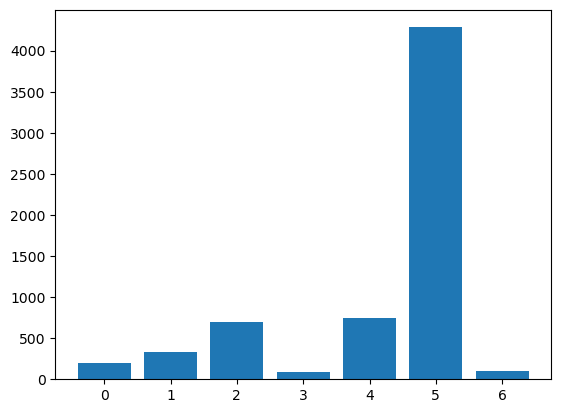

In [69]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder
le = LabelEncoder()

# Fit the label encoder and transform y_train
y_train_encoded = le.fit_transform(y_train)

# Now you can count the occurrences of each class
counts = np.bincount(y_train_encoded)

# Create a bar plot
plt.bar(range(len(counts)), counts)

# Show the plot
plt.show()

In [70]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
f = LR.fit(X_train_flat, y_train)

/Users/lizrightmire/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [71]:
X_train_flat

tensor([[168., 176., 178.,  ...,  90.,  56.,  31.],
        [140., 148., 154.,  ..., 124., 109.,  93.],
        [242., 234., 240.,  ..., 151., 147., 145.],
        ...,
        [215., 218., 220.,  ..., 118., 116., 109.],
        [164., 168., 172.,  ..., 153., 139., 137.],
        [145., 153., 154.,  ..., 166., 166., 159.]])

In [72]:
LR.score(X_train_flat, y_train)

0.7017571139791634

### Convolutional Neural Net
We already flattened the data, so that's pretty cool!

In [73]:
from torch.nn import Conv2d, MaxPool2d, Parameter
from torch.nn.functional import relu

import torch.nn as nn
from  torch.nn import ReLU

In [74]:
print(X_train['img'].iloc[0].shape)
print(X_test['img'].iloc[0].shape)

(3, 32, 32)
(3, 32, 32)


In [75]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
print(y_train)

# Fit the encoder on the training data
le.fit(y_train)

# Transform y_train and y_test using the fitted encoder
y_train = le.transform(y_train)
y_test = le.transform(y_test)

LEClasses = le.classes_

1156     df
373     bkl
5382     nv
6162     nv
7735     nv
       ... 
6604     nv
6832     nv
1081    bkl
9457     nv
9031     nv
Name: dx, Length: 6431, dtype: object


In [76]:
X_train_img = torch.stack([torch.from_numpy(img) for img in X_train['img'].tolist()])
y_train = torch.Tensor(y_train.tolist())

X_test_img = torch.stack([torch.from_numpy(img) for img in X_test['img'].tolist()])
y_test = torch.Tensor(y_test.tolist())

In [77]:
data_loader_train = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train_img, y_train),
    batch_size = 100,
    shuffle = True
)

data_loader_val = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_test_img, y_test),
    batch_size = 100,
    shuffle = True
)

X, y = next(iter(data_loader_train))

In [78]:
def evaluate(model, multichannel = False):

    # count the number of total observations and correct predictions
    total = 0
    total_correct = 0

    # loop through the data loader
    for X, y in data_loader_val:
        X = X.float()
        y = y.long()

        # used for evaluating ImageNet later
        if multichannel:
            X = torch.tile(X, dims = (1, 3, 1, 1))

        # move the data to the device (ideally, to gpu)

        # compute the predictions
        scores = model.forward(X)
        y_pred =  torch.argmax(scores, dim = 1)

        # update the total and the number of correct predictions
        total += X.size(0)
        total_correct += (y_pred == y).sum().item()

    print(f"validation accuracy = {total_correct / total:.3f}")
#--

In [79]:
import torch.optim as optim
def train(model, k_epochs = 1, print_every = 2000, evaluate_after_epoch = True, multichannel = False, **opt_kwargs):

        # loss function is cross-entropy (multiclass logistic)
    loss_fn = nn.CrossEntropyLoss()

    # optimizer is SGD with momentum
    optimizer = optim.SGD(model.parameters(), **opt_kwargs)

    for epoch in range(k_epochs):
        for i, data in enumerate(data_loader_train):
            X, y = data
            X = X.float()
            y = y.long()
            
            if multichannel:
                X = torch.tile(X, dims = (1, 3, 1, 1))

            # clear any accumulated gradients
            optimizer.zero_grad()

            # compute the loss
            y_pred = model(X)
            loss   = loss_fn(y_pred, y)

            # compute gradients and carry out an optimization step
            loss.backward()
            optimizer.step()

            if (i + 1) % print_every == 0:
                print(f"Epoch {epoch}, batch {i:>3}, loss on batch: {loss.item():.3f}")

        if evaluate_after_epoch:
            print(f"Epoch {epoch}: ", end = "")
            evaluate(model)

In [80]:
class ConvNet_Simplest(nn.Module):
    def __init__(self):
        super().__init__()

        self.pipeline = torch.nn.Sequential(
            nn.Flatten(),
            nn.Linear(3072, 32)
        )

    def forward(self, x):
        return self.pipeline(x)
    
class ConvNet_class(nn.Module):
    def __init__(self):
        super().__init__()

        self.pipeline = torch.nn.Sequential(
            nn.Conv2d(3, 100, 5),
            ReLU(),
            nn.Conv2d(100, 50, 3),
            ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(50, 50, 3),
            ReLU(),
            nn.Conv2d(50, 50, 3),
            ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(800, 512),
            ReLU(),
            nn.Linear(512, 128),
            ReLU(),
            nn.Linear(128, 7)
        )

    def forward(self, x):
        return self.pipeline(x)

class ConvNet_Dropout(nn.Module):
    def __init__(self):
        super().__init__()

        self.pipeline = torch.nn.Sequential(
            nn.Conv2d(3, 100, 5),
            ReLU(),
            nn.Conv2d(100, 50, 3),
            ReLU(),
            nn.MaxPool2d(2, 2),
            #nn.Dropout(0.25),
            nn.Conv2d(50, 50, 3),
            ReLU(),
            nn.Conv2d(50, 50, 3),
            ReLU(),
            nn.MaxPool2d(2, 2),
            #nn.Dropout(0.05),
            nn.Flatten(),
            nn.Linear(800, 512),
            ReLU(),
            nn.Linear(512, 128),
            ReLU(),
            nn.Linear(128, 7)
        )

    def forward(self, x):
        return self.pipeline(x)

Start with a very simple neural network:

In [81]:
model = ConvNet_Simplest()
from torchsummary import summary
summary(model, input_size=(3, 32, 32))
train(model, k_epochs = 15, lr = 0.1, evaluate_after_epoch = True, momentum = 0.9)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                   [-1, 32]          98,336
Total params: 98,336
Trainable params: 98,336
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 0.38
Estimated Total Size (MB): 0.41
----------------------------------------------------------------


Epoch 0: validation accuracy = 0.529
Epoch 1: validation accuracy = 0.584
Epoch 2: validation accuracy = 0.464
Epoch 3: validation accuracy = 0.655
Epoch 4: validation accuracy = 0.435
Epoch 5: validation accuracy = 0.650
Epoch 6: validation accuracy = 0.636
Epoch 7: validation accuracy = 0.463
Epoch 8: validation accuracy = 0.297
Epoch 9: validation accuracy = 0.532
Epoch 10: validation accuracy = 0.476
Epoch 11: validation accuracy = 0.484
Epoch 12: validation accuracy = 0.550
Epoch 13: validation accuracy = 0.638
Epoch 14: validation accuracy = 0.541


What about the model we used in class?

In [82]:
model = ConvNet_class()
train(model, k_epochs = 5, lr = 0.01, evaluate_after_epoch = True, momentum = 0.9)

Epoch 0: validation accuracy = 0.654
Epoch 1: validation accuracy = 0.654
Epoch 2: validation accuracy = 0.654
Epoch 3: validation accuracy = 0.654
Epoch 4: validation accuracy = 0.654


oof. That's not good!

What if we try including dropout?

In [83]:
model = ConvNet_Dropout()
train(model, k_epochs = 5, lr = 0.1, evaluate_after_epoch = True, momentum = 0.9)

Epoch 0: validation accuracy = 0.037
Epoch 1: validation accuracy = 0.037
Epoch 2: validation accuracy = 0.037
Epoch 3: validation accuracy = 0.037
Epoch 4: validation accuracy = 0.037


Let's try a model as recommended by a scientific paper on this problem

In [84]:
import torch.nn.functional as F

class ConvNet_Expert(nn.Module):
    def __init__(self):
        super().__init__()

        self.pipeline = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=3),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.25),

            nn.Flatten(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(1024, 7),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.pipeline(x)

In [85]:
model = ConvNet_Expert()
train(model, k_epochs = 5, lr = 0.1, evaluate_after_epoch = True, momentum = 0.9)

Epoch 0: validation accuracy = 0.654
Epoch 1: validation accuracy = 0.654
Epoch 2: validation accuracy = 0.654
Epoch 3: validation accuracy = 0.654
Epoch 4: validation accuracy = 0.654


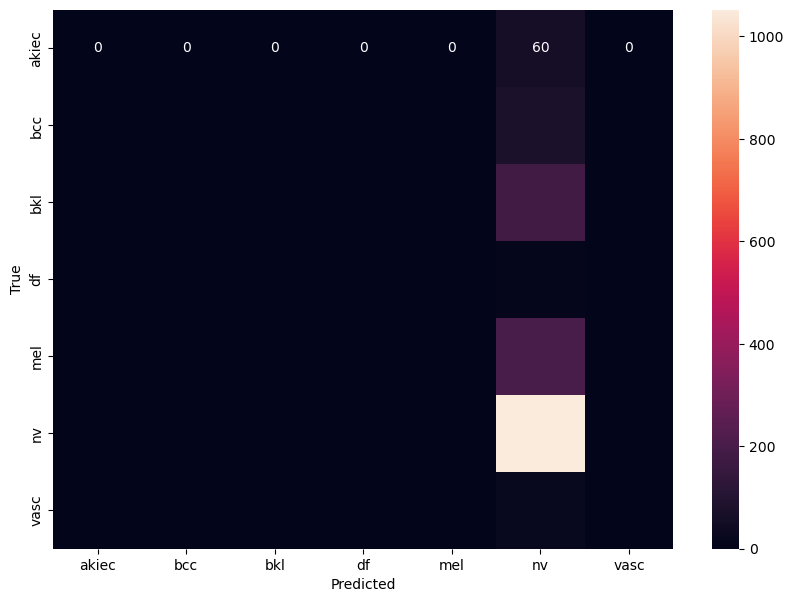

In [87]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming that data_loader is your test data loader
def get_all_preds(model, data_loader_val):
    all_preds = torch.tensor([])
    for batch in data_loader_val:
        images, labels = batch

        # Convert images to float
        images = images.float()

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

with torch.no_grad():
    model.eval()
    y_pred = get_all_preds(model, data_loader_val)
    y_pred = np.argmax(y_pred, axis=1)

# Assuming that y_test are your true labels
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=LEClasses, yticklabels=LEClasses)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

This is not much better than the simplest neural net

### Data Augmentation

Example of random crop and flip on an example image

original image


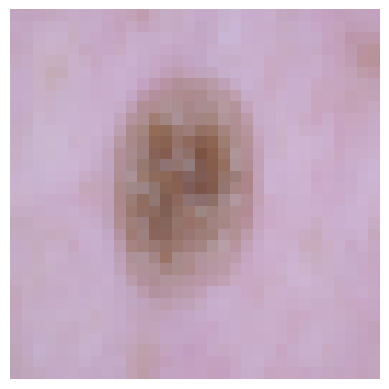

transformed image


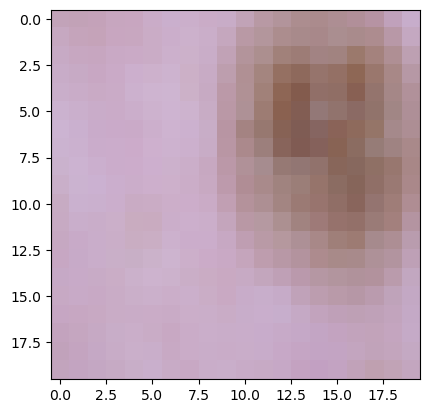

In [ ]:
from PIL import Image

# Experiment with a sample of the data
X_train_flat = X_train_flat[1:10]

from torchvision.transforms import v2
transforms = v2.Compose([
    v2.RandomResizedCrop(size=(20, 20), antialias=True),
    v2.RandomHorizontalFlip(p=1)
    ])

# original image
print("original image")
plt.imshow(df_data['img'].iloc[10], cmap = "Greys_r")
plt.gca().axis("off")
plt.show()

# transformed image
print("transformed image")
img = Image.fromarray(df_data["img"].iloc[10])
img = transforms(img)
plt.imshow(img)